In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf
import tensorflow.keras.backend as kb
tfd = tfp.distributions

seed = 1
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 80

In [2]:
def build_kernel_matrix(num_datapoints, input_datapoints, kernel_fn, input_rhs):
    """
    Constructs the full kernel matrix element by element
    :return: tf.Tensor, (num_points, num_points)
    """
    kernel_mat = tf.Variable(tf.zeros((num_datapoints, num_datapoints), dtype=tf.float32))

    for i in range(num_datapoints):
        for j in range(i, num_datapoints):
            inputs_i = tf.expand_dims(tf.constant(input_datapoints[i]), 0)  # (1, d)
            inputs_j = tf.expand_dims(tf.constant(input_datapoints[j]), 0)  # (1, d)
            with tf.GradientTape() as tape1:
                tape1.watch(inputs_i)
                with tf.GradientTape() as tape2:
                    tape2.watch(inputs_j)
                    kernel_output = kernel_fn.apply(tf.expand_dims(inputs_i, 0), tf.expand_dims(inputs_j, 0))  # (1, 1, 1)
                    kernel_output = tf.squeeze(kernel_output)  # scalar
                grads2 = tape2.gradient(kernel_output, inputs_j)  # (d,)
                first_inner_product = tf.reduce_sum(grads2 * input_rhs[j])  # scalar
            grads1 = tape1.gradient(first_inner_product, inputs_i)  # (d,) # this becomes nan when taking gradient of value 0 (when x=y)
            second_inner_product = tf.reduce_sum(grads1 * input_rhs[i])  # scalar
            kernel_mat[i, j].assign(second_inner_product)
            if i != j:
                kernel_mat[j, i].assign(second_inner_product)
    K = tf.constant(kernel_mat.numpy())
    return K

In [3]:
def build_lyapunov_function(xs, a, num_datapoints, input_datapoints, kernel_fn, input_rhs):
    """
    Constructs Lyapunov function approximation
    xs - (n_x, 2) points to be evaluated
    a - (n_y, 1) alpha coefficients
    num_datapoints - n_y
    input_datapoints - (n_y, 2) datapoints
    kernel_fn - function to calculate kernel
    input_rhs - (n_y, 2) evaluated g at input_points
    :return: tf.Tensor , (n_x,)
    """
    mat = tf.Variable(tf.zeros((num_datapoints,), dtype=tf.float32))
    all_s = tf.Variable(tf.zeros((xs.shape[0],), dtype=tf.float32))
    for i in range(xs.shape[0]):
        for j in range(num_datapoints):
            inputs_i = tf.expand_dims(tf.constant(xs[i]), 0)  # (1, d)
            inputs_j = tf.expand_dims(tf.constant(input_datapoints[j]), 0)  # (1, d)
            with tf.GradientTape() as tape:
                tape.watch(inputs_j)
                kernel_output = kernel_fn.apply(tf.expand_dims(inputs_i, 0), tf.expand_dims(inputs_j, 0))  # (1, 1, 1)
                kernel_output = tf.squeeze(kernel_output)  # scalar
            grads = tape.gradient(kernel_output, inputs_j)  # (d,)
            inner_product = tf.reduce_sum(grads * input_rhs[j])  # scalar
            mat[j].assign(inner_product)
        all_lambda = tf.constant(mat.numpy()) # (num_datapoints,)
        s = tf.reduce_sum(tf.squeeze(a) * all_lambda) # scalar
        all_s[i].assign(s)
    solution = tf.constant(all_s.numpy()) # (len(x),)
    return solution

In [4]:
g_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()
n_y = 90
dim = 2
bounds = [1.6, 4]

x = np.linspace(-bounds[0], bounds[0], 6)
y = np.linspace(-bounds[1], bounds[1], 15)
X, Y = np.meshgrid(x, y)
s = X.shape
data = np.zeros((6*15,dim)) 

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        data[c,0] = X[i,j]
        data[c,1] = Y[i,j]
        c = c+1;

data_points = tf.constant(data, tf.float32) # (n_y, dim)
                   
# van poole equation
def vf(x):
    y = [-x[:,1], x[:,0] + (1-x[:,0]**2)*x[:,1]]
    return y

input_RHS =  tf.transpose(tf.convert_to_tensor(vf(data_points), dtype=tf.float32))  # (n_y, dim)

beta = -tf.square(tf.norm(data_points, ord = 2, axis=1))[..., tf.newaxis] # (n_y, 1)
A = build_kernel_matrix(n_y, data_points, g_kernel, input_RHS) # (n_y, n_y)

alphas = tf.linalg.solve(A, beta) # (n_y, 1)

2022-07-29 11:45:05.096763: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


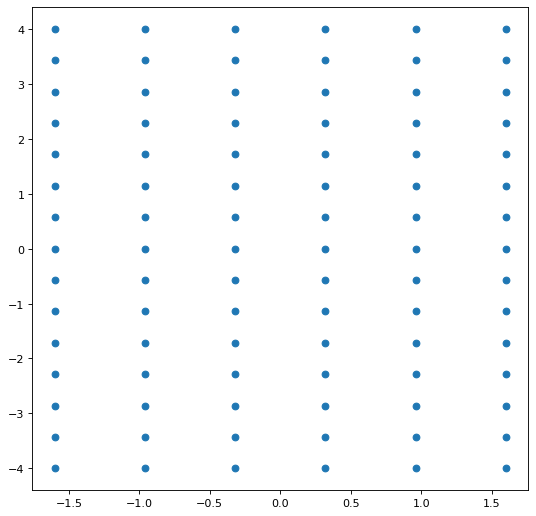

In [5]:
plt.scatter(data_points[:,0], data_points[:,1])

In [6]:
# x = np.linspace(-bounds[0], bounds[0], 6)
# y = np.linspace(-bounds[1], bounds[1], 15)
# X, Y = np.meshgrid(x, y)
# s = X.shape
# data = np.zeros((6*15,dim)) 

# # convert mesh into point vector for which the model can be evaluated
# c = 0
# for i in range(s[0]):
#     for j in range(s[1]):
#         data[c,0] = X[i,j]
#         data[c,1] = Y[i,j]
#         c = c+1;
# data

In [7]:
# number of x points
n_x = 20
x = np.linspace(-bounds[0], bounds[0], n_x)
y = np.linspace(-bounds[1], bounds[1], n_x)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((n_x**2,dim)) 

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;
# define vector field for plot
new_vf = np.reshape(np.array(vf(DT)), (dim, n_x, n_x))

In [8]:
# calculates the lyapunov function approximation
solution = build_lyapunov_function(tf.constant(DT, tf.float32), alphas, n_y, data_points, g_kernel, input_RHS)

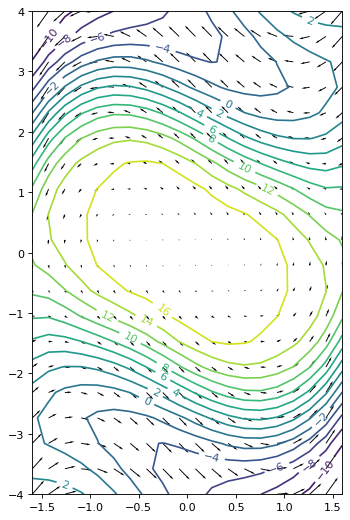

In [9]:
solution = tf.reshape(solution, (n_x, n_x))
plt.figure(figsize=(5,8))
cp = plt.contour(x,y, solution, levels=15)
plt.quiver(X,Y, new_vf[0], new_vf[1], headwidth=2, headlength=4)
plt.clabel(cp, inline=True, fontsize=10)
plt.show()

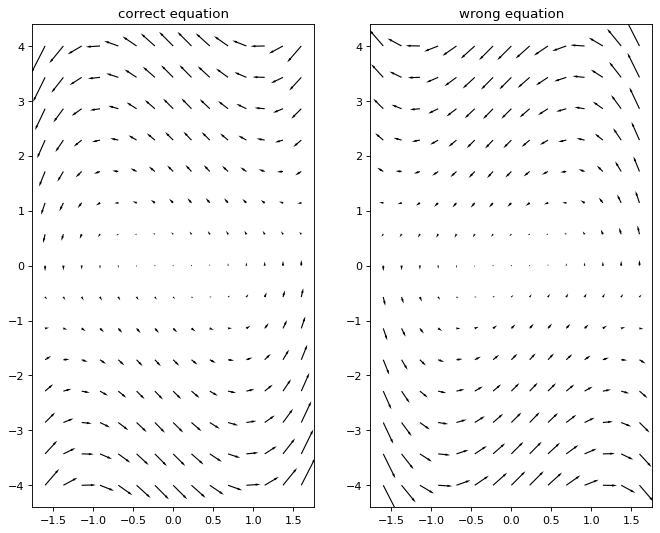

In [23]:
# van poole equation
def wrong_vf(x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return y

# number of x points
n_x = 15
x = np.linspace(-bounds[0], bounds[0], n_x)
y = np.linspace(-bounds[1], bounds[1], n_x)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((n_x**2,dim)) 

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;
# define vector field for plot
new_vf = np.reshape(np.array(vf(DT)), (dim, n_x, n_x))
old_vf =  np.reshape(np.array(wrong_vf(DT)), (dim, n_x, n_x))


plt.figure(figsize=(10,8))
plt.subplot(121)
q1 = plt.quiver(X,Y, new_vf[0], new_vf[1], headwidth=2, headlength=4)
plt.title('correct equation')

plt.subplot(122)
q2 = plt.quiver(X,Y, old_vf[0], old_vf[1], headwidth=2, headlength=4)
plt.title('wrong equation')
plt.show()